In [2]:
# System
import os

# Time
import time
import datetime

# Numerical
import numpy as np
import pandas as pd

# NLP
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# from pywsd.utils import lemmatize_sentence

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

# Deep Learing Preprocessing - Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Deep Learning Model - Keras
from keras.models import Model
from keras.models import Sequential
# Deep Learning Model - Keras - CNN
from keras.layers import Conv1D, Conv2D, Convolution1D, MaxPooling1D, SeparableConv1D, SpatialDropout1D, \
    GlobalAvgPool1D, GlobalMaxPool1D, GlobalMaxPooling1D 
from keras.layers.pooling import _GlobalPooling1D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Embedding
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply



# Deep Learning Parameters - Keras
from keras.optimizers import RMSprop, Adam

# Deep Learning Callbacs - Keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.layers import MaxPooling3D, GlobalMaxPooling3D, GlobalAveragePooling3D
# Visualization


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load data

In [3]:
books_neg = pd.read_csv("sorted_data_acl/books/books_negative.csv")
books_pos = pd.read_csv("sorted_data_acl/books/books_positive.csv")
dvd_neg = pd.read_csv("sorted_data_acl/dvd/dvd_negative.csv")
dvd_pos = pd.read_csv("sorted_data_acl/dvd/dvd_positive.csv")
ele_neg = pd.read_csv("sorted_data_acl/electronics/electronics_negative.csv")
ele_pos = pd.read_csv("sorted_data_acl/electronics/electronics_positive.csv")
kit_neg = pd.read_csv("sorted_data_acl/kitchen_&_housewares/kitchen_negative.csv")
kit_pos = pd.read_csv("sorted_data_acl/kitchen_&_housewares/kitchen_positive.csv")

#dvd_test = pd.read_csv("sorted_data_acl/dvd/dvd_unlabeled.csv")
ele_test = pd.read_csv("sorted_data_acl/electronics/electronics_unlabeled.csv")
kit_test = pd.read_csv("sorted_data_acl/kitchen_&_housewares/kitchen_unlabeled.csv")

In [4]:
books_neg['label'] = 0 
books_pos['label'] = 1
books = pd.concat([books_neg,books_pos],axis = 0)
books['domain'] = 'books'
dvd_neg['label'] = 0
dvd_pos['label'] = 1
dvd = pd.concat([dvd_pos, dvd_neg],axis = 0)
dvd['domain'] = 'dvd'
ele_neg['label'] = 0
ele_pos['label'] = 1
ele = pd.concat([ele_neg, ele_pos],axis = 0)
ele['domain'] = 'electronics'
kit_neg['label'] = 0
kit_pos['label'] = 1
kit = pd.concat([kit_neg, kit_pos],axis = 0)
kit['domain'] = 'kitchen'
alldata = pd.concat([books,dvd,ele,kit])

In [5]:
books =books.reset_index(drop=True)
dvd =dvd.reset_index(drop=True)
ele =ele.reset_index(drop=True)
kit =kit.reset_index(drop=True)

In [6]:
books.describe(),dvd.describe(),ele.describe(),kit.describe()

(             label
 count  2000.000000
 mean      0.500000
 std       0.500125
 min       0.000000
 25%       0.000000
 50%       0.500000
 75%       1.000000
 max       1.000000,
              label
 count  2000.000000
 mean      0.500000
 std       0.500125
 min       0.000000
 25%       0.000000
 50%       0.500000
 75%       1.000000
 max       1.000000,
              label
 count  2000.000000
 mean      0.500000
 std       0.500125
 min       0.000000
 25%       0.000000
 50%       0.500000
 75%       1.000000
 max       1.000000,
              label
 count  2000.000000
 mean      0.500000
 std       0.500125
 min       0.000000
 25%       0.000000
 50%       0.500000
 75%       1.000000
 max       1.000000)

In [7]:
books.head()

,unique_id,asin,product_name,product_type,helpful,rating,title,date,reviewer,reviewer_location,review_text,label,domain
0,"\n0312355645:horrible_book,_horrible.:mark_gos...",\n0312355645\n,\nRunning with Scissors: A Memoir: Books: Augu...,\nbooks\n,\n4 of 9\n,\n1.0\n,"\nHorrible book, horrible.\n","\nNovember 14, 2006\n",\nMark Gospri\n,NaN,\nTHis book was horrible. If it was possible ...,0,books
1,\n1559278676:shallow_self-indulgence:joseph_s....,\n1559278676\n,\nRunning with Scissors: A Memoir: Books: Augu...,\nbooks\n,\n1 of 6\n,\n1.0\n,\nshallow self-indulgence\n,"\nNovember 15, 2006\n","\nJoseph S. Perrott ""avid reader""\n","\nphiladelphia, pa. United States\n",\nI like to use the Amazon reviews when purcha...,0,books
2,"\n1559278676:horrible_book,_horrible.:mark_gos...",\n1559278676\n,\nRunning with Scissors: A Memoir: Books: Augu...,\nbooks\n,\n4 of 9\n,\n1.0\n,"\nHorrible book, horrible.\n","\nNovember 14, 2006\n",\nMark Gospri\n,NaN,\nTHis book was horrible. If it was possible ...,0,books
3,"\n0425193373:disappointment:reader_""reader""\n",\n0425193373\n,\nFierce Conversations: Achieving Sucess at Wo...,\nbooks\n,\n10 of 13\n,\n1.0\n,\nDisappointment\n,"\nMarch 13, 2006\n","\nReader ""Reader""\n",NaN,"\nI'm not sure who's writing these reviews, bu...",0,books
4,\n0142004030:a_disappointing_mess:a._ross\n,\n0142004030\n,\nLost in a Good Book (Thursday Next Novels): ...,\nbooks\n,\n6 of 7\n,\n2.0\n,\nA Disappointing Mess\n,"\nMay 17, 2006\n",\nA. Ross\n,"\nWashington, DC\n",\nI picked up the first book in this series (T...,0,books


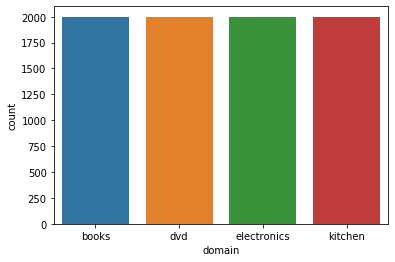

In [8]:
sns.countplot(x='domain',data=alldata)

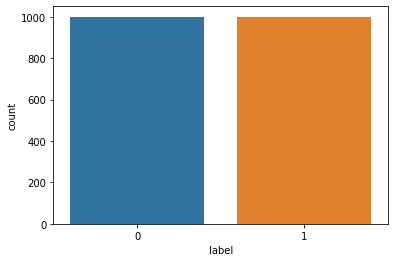

In [9]:
sns.countplot(x='label',data=dvd,order=[0,1])

# data cleaning

In [10]:
x_books = books['review_text']
y_books = books['label']

x_dvd = dvd['review_text']
y_dvd = dvd['label']

x_ele = ele['review_text']
y_ele = ele['label']

x_kit = kit['review_text']
y_kit = kit['label']

In [11]:
x_books.shape

(2000,)

In [12]:
def clean_doc(doc):
    #split into words
    tokens = word_tokenize(doc)
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    #prepare regex for char filtering
    re_punc =re.compile('[%s]'% re.escape(string.punctuation))
    #remove punctuation
    stripped =[re_punc.sub('',w) for w in tokens]
    #filter out stop words
    #stop_words = set(stopwords.words('english'))
    #words =[w for w in words if not w in stop_words]
    #remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    #filter out short tokens
    tokens = [word for word in words if len(word)>1]
    return tokens

In [13]:
text_books = []
for m in range(0,len(x_books)):
    X = ''.join(str(i)for i in x_books[m])
    te = clean_doc(X)
    trainx = " ".join(te)
    text_books.append(trainx)

In [14]:
text_dvd = []
for m in range(0,len(x_dvd)):
    X = ''.join(str(i)for i in x_dvd[m])
    te = clean_doc(X)
    trainx = " ".join(te)
    text_dvd.append(trainx)

In [15]:
text_ele = []
for m in range(0,len(x_ele)):
    X = ''.join(str(i)for i in x_ele[m])
    te = clean_doc(X)
    trainx = " ".join(te)
    text_ele.append(trainx)

In [16]:
text_kit = []
for m in range(0,len(x_kit)):
    X = ''.join(str(i)for i in x_kit[m])
    te = clean_doc(X)
    trainx = " ".join(te)
    text_kit.append(trainx)

#### TF-iDF& ML models

In [17]:
vectorizer = TfidfVectorizer()

In [18]:
X_books = vectorizer.fit_transform(text_books)
X_dvd = vectorizer.fit_transform(text_dvd)
X_ele = vectorizer.fit_transform(text_ele)
X_kit = vectorizer.fit_transform(text_kit)

In [19]:
X_books.shape, y_books.shape

((2000, 26106), (2000,))

In [20]:
model_rf = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=1)


In [21]:
rf_b = cross_val_score(model_rf, X_books, y_books, cv=3).mean()
rf_d = cross_val_score(model_rf, X_dvd, y_dvd, cv=3).mean()
rf_e = cross_val_score(model_rf, X_ele, y_ele, cv=3).mean()
rf_k = cross_val_score(model_rf, X_kit, y_kit, cv=3).mean()

In [22]:
print('books randomforest',rf_b)

books randomforest 0.6140128134131132


In [23]:
print('dvd randomforest',rf_d)

dvd randomforest 0.6464853159006082


In [24]:
print('ele randomforest',rf_e)

ele randomforest 0.6604970787879334


In [25]:
print('kit randomforest',rf_k)

kit randomforest 0.6539988264126194


In [26]:
model_lr = LogisticRegression()

In [27]:
lr_b = cross_val_score(model_lr, X_books, y_books, cv=3).mean()
lr_d = cross_val_score(model_lr, X_dvd, y_dvd, cv=3).mean()
lr_e = cross_val_score(model_lr, X_ele, y_ele, cv=3).mean()
lr_k = cross_val_score(model_lr, X_kit, y_kit, cv=3).mean()

In [28]:
print('books logisticregression',lr_b)

books logisticregression 0.7750051400726062


In [29]:
print('dvd logisticregression',lr_d)

dvd logisticregression 0.7784801293047169


In [30]:
print('ele logisticregression',lr_e)

ele logisticregression 0.8040019029524276


In [31]:
print('kit logisticregression',lr_k)

kit logisticregression 0.8250071660866265


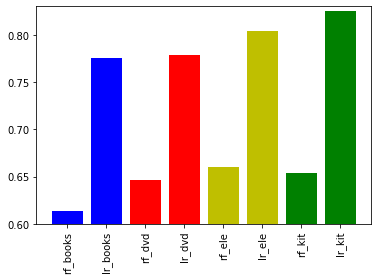

In [32]:
# ML model Accuracy
fig= plt.figure()
ax= plt.axes
objects = ['rf_books','lr_books','rf_dvd','lr_dvd','rf_ele','lr_ele','rf_kit','lr_kit']
x = np.arange(len(objects),dtype=float)
y = np.array([rf_b,lr_b,rf_d,lr_d,rf_e,lr_e,rf_k,lr_k],dtype=float)
plt.bar(x,y,align='center',color=['b','b','r','r','y','y','g','g'])
plt.ylim([0.6,0.83])
plt.xticks(x,objects,rotation=90)
#plt.ylabel('Accurancy')
#plt.xlabel('models')
#plt.title('Accuracy of different models')
plt.show()

# baseline CNN model

In [33]:
#pre process

In [34]:
label_encoder = LabelEncoder()

Y_books = label_encoder.fit_transform(y_books)
Y_books = to_categorical(Y_books)
Y_books.shape

(2000, 2)

In [35]:
Y_dvd = label_encoder.fit_transform(y_dvd)
Y_dvd = to_categorical(Y_dvd)
Y_dvd.shape

(2000, 2)

In [36]:
Y_ele = label_encoder.fit_transform(y_ele)
Y_ele = to_categorical(Y_ele)
Y_ele.shape

(2000, 2)

In [37]:
Y_kit = label_encoder.fit_transform(y_kit)
Y_kit = to_categorical(Y_kit)
Y_kit.shape

(2000, 2)

In [38]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(text_books, Y_books, test_size=0.15)

In [39]:
max_words_b = len(set(" ".join(text_books).split()))
max_len_b = max([len(s.split()) for s in text_books])
max_words_b, max_len_b

(26106, 3227)

In [40]:
max_words_d = len(set(" ".join(text_dvd).split()))
max_len_d = max([len(s.split()) for s in text_dvd])
max_words_d, max_len_d

(25851, 1415)

In [41]:
max_words_e = len(set(" ".join(text_ele).split()))
max_len_e = max([len(s.split()) for s in text_ele])
max_words_e, max_len_e

(13490, 918)

In [42]:
max_words_k = len(set(" ".join(text_kit).split()))
max_len_k = max([len(s.split()) for s in text_kit])
max_words_k, max_len_k

(11674, 958)

In [43]:
max_words = max(max_words_b,max_words_d,max_words_e,max_words_k)
max_len = max(max_len_b,max_len_d,max_len_e,max_len_k)

In [44]:
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train_b)

X_train_b_seq = tokenizer.texts_to_sequences(X_train_b)
X_train_b_seq = sequence.pad_sequences(X_train_b_seq, maxlen=max_len)


In [45]:
tokenizer.fit_on_texts(X_test_b)

X_test_b_seq = tokenizer.texts_to_sequences(X_test_b)
X_test_b_seq = sequence.pad_sequences(X_test_b_seq, maxlen=max_len)

In [46]:
X_train_b_seq.shape,X_test_b_seq.shape

((1700, 3227), (300, 3227))

In [47]:
def get_cnn_model(num_class=2):   
    model = Sequential()
    
    model.add(Embedding(max_words, 100, input_length=max_len))
    
    model.add(Conv1D(1024, 2, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(2048, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(num_class, activation='softmax'))
    model.summary()
    return model

In [48]:
def plot_performance(history=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    plt.show()

### performance in one domain

In [49]:
loss = 'binary_crossentropy'
metrics = ['accuracy']

In [50]:
learning_rate = 0.01
optimizer = Adam(learning_rate)

In [51]:
num_class = 2
model1 = get_cnn_model(num_class=num_class)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3227, 100)         2610600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3226, 1024)        205824    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
__________

In [68]:
# fit network
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history1 = model1.fit(X_train_b_seq, Y_train_b, validation_data=(X_test_b_seq, Y_test_b),batch_size=128,epochs=20)

Train on 1700 samples, validate on 300 samples
Epoch 1/20
1700/1700 [==============================] - 488s 287ms/step - loss: 2.3708 - acc: 0.5088 - val_loss: 0.9981 - val_acc: 0.5900
Epoch 2/20
1700/1700 [==============================] - 473s 278ms/step - loss: 2.3814 - acc: 0.5588 - val_loss: 1.3808 - val_acc: 0.5967
Epoch 3/20
1700/1700 [==============================] - 457s 269ms/step - loss: 2.0483 - acc: 0.5735 - val_loss: 1.8003 - val_acc: 0.5800
Epoch 4/20
1700/1700 [==============================] - 450s 265ms/step - loss: 1.7458 - acc: 0.6124 - val_loss: 1.3615 - val_acc: 0.5767
Epoch 5/20
1700/1700 [==============================] - 443s 260ms/step - loss: 1.3040 - acc: 0.6759 - val_loss: 1.5295 - val_acc: 0.5600
Epoch 6/20
1700/1700 [==============================] - 431s 254ms/step - loss: 1.0186 - acc: 0.7582 - val_loss: 1.8651 - val_acc: 0.5633
Epoch 7/20
1700/1700 [==============================] - 429s 252ms/step - loss: 0.7710 - acc: 0.8294 - val_loss: 2.1527 - val

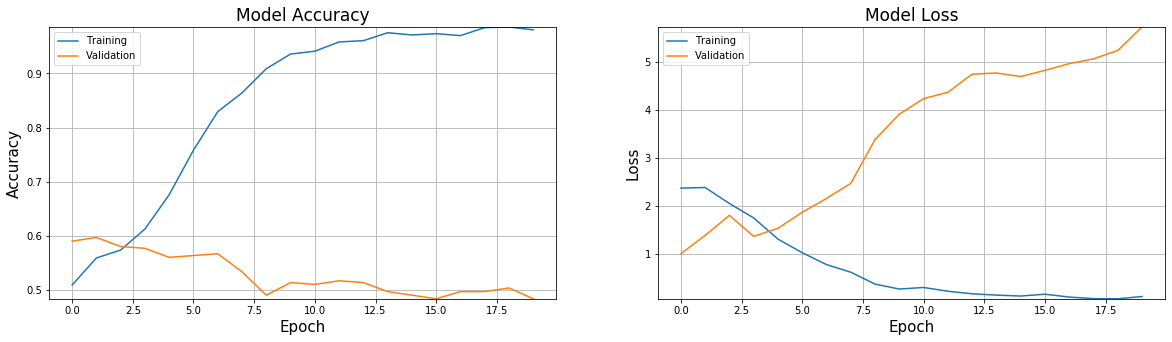

In [71]:
plot_performance(history=history1)

#### in multiple domain

In [52]:
tokenizer.fit_on_texts(text_books)

X_b_seq = tokenizer.texts_to_sequences(text_books)
X_b_seq = sequence.pad_sequences(X_b_seq, maxlen=max_len)

In [53]:
tokenizer.fit_on_texts(text_dvd)

X_d_seq = tokenizer.texts_to_sequences(text_dvd)
X_d_seq = sequence.pad_sequences(X_d_seq, maxlen=max_len)

In [54]:
tokenizer.fit_on_texts(text_ele)

X_e_seq = tokenizer.texts_to_sequences(text_ele)
X_e_seq = sequence.pad_sequences(X_e_seq, maxlen=max_len)

In [55]:
tokenizer.fit_on_texts(text_kit)

X_k_seq = tokenizer.texts_to_sequences(text_kit)
X_k_seq = sequence.pad_sequences(X_k_seq, maxlen=max_len)

In [76]:
history_b_d = model1.fit(X_b_seq, Y_books, validation_data=(X_d_seq, Y_dvd),batch_size=128,epochs=20)

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 538s 269ms/step - loss: 3.6463 - acc: 0.5150 - val_loss: 1.8669 - val_acc: 0.4985
Epoch 2/20
2000/2000 [==============================] - 532s 266ms/step - loss: 1.9161 - acc: 0.6015 - val_loss: 1.7882 - val_acc: 0.5110
Epoch 3/20
2000/2000 [==============================] - 527s 264ms/step - loss: 1.4799 - acc: 0.6535 - val_loss: 1.5499 - val_acc: 0.5200
Epoch 4/20
2000/2000 [==============================] - 517s 259ms/step - loss: 1.0364 - acc: 0.7435 - val_loss: 2.9423 - val_acc: 0.5135
Epoch 5/20
2000/2000 [==============================] - 518s 259ms/step - loss: 0.7617 - acc: 0.8300 - val_loss: 2.5536 - val_acc: 0.5145
Epoch 6/20
2000/2000 [==============================] - 527s 264ms/step - loss: 0.5307 - acc: 0.8665 - val_loss: 3.3002 - val_acc: 0.5255
Epoch 7/20
2000/2000 [==============================] - 521s 261ms/step - loss: 0.4207 - acc: 0.9110 - val_loss: 3.2628 - va

In [57]:
model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history_b_e = model1.fit(X_b_seq, Y_books, validation_data=(X_e_seq, Y_ele),batch_size=128,epochs=20)

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 457s 228ms/step - loss: 2.4521 - acc: 0.5245 - val_loss: 3.3541 - val_acc: 0.5025
Epoch 2/20
2000/2000 [==============================] - 442s 221ms/step - loss: 2.0607 - acc: 0.5780 - val_loss: 3.0588 - val_acc: 0.5150
Epoch 3/20
2000/2000 [==============================] - 460s 230ms/step - loss: 1.8559 - acc: 0.6015 - val_loss: 1.9673 - val_acc: 0.4885
Epoch 4/20
2000/2000 [==============================] - 435s 217ms/step - loss: 1.4873 - acc: 0.6570 - val_loss: 2.0155 - val_acc: 0.4590
Epoch 5/20
2000/2000 [==============================] - 441s 220ms/step - loss: 1.1565 - acc: 0.7405 - val_loss: 1.8670 - val_acc: 0.4985
Epoch 6/20
2000/2000 [==============================] - 442s 221ms/step - loss: 0.8230 - acc: 0.8025 - val_loss: 2.3801 - val_acc: 0.4950
Epoch 7/20
2000/2000 [==============================] - 440s 220ms/step - loss: 0.5790 - acc: 0.8645 - val_loss: 2.9083 - va

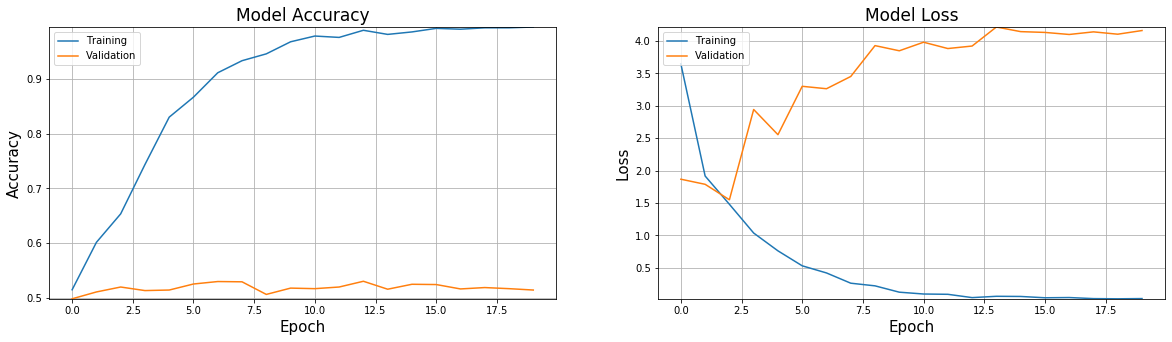

In [77]:
plot_performance(history=history_b_d)

In [ ]:
plot_performance(history=history_b_e)

plot_performance(history=history_b_k)